# __Training and tuning neural network__
- Dataset: Guarujá Municipality - São Paulo - Brazil
- Part 2/3

## Authorship:
        Caio Azevedo
        São Paulo University, October, 2023

## Main goals:


__Objetivos__:

- Tratamento dos dados para aplicação da rede neural: 
   - remoção de features irrelevantes;
   - normalização do dataset;
   - separação do dados de treino e teste da rede neural

- Treinamento e avaliação das redes neurais:
   - implementação keras
   - implementação customizada

- Automação do setup dos hiperparâmetros para melhor desempenho (critério inicial acurácia).
  - em __15-08-2021__ - Uso Keras Tuning para otimização dos hyperparameters Keras (vide arquivo .ipynb)
  - em __29-08-2021__ - Força Bruta para otimização dos hiperparametros na rede customizada

- Avaliar performance da rede com e sem 'features irrelevantes'.

__Sobre a implementação da Rede Neural Proprietária__:

1. ref. https://whimsical.com/artificial-neural-network-4cTMNjQBkkCwJHZhUy7BTV


Comparando predição com rede do keras
- ref. https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

Tunning neural netowrks
- ref. http://karpathy.github.io/2019/04/25/recipe/

Sobre as métricas
- ref. https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc

## Coding

### Imported libraries

In [1]:
import datetime
start = datetime.datetime.now()

In [2]:
import Rede_Neural as rna
from Rede_Neural import NeuralNetwork
from Rede_Neural import Layer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
import seaborn as sns

from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from utils import plot

%matplotlib inline

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

### Auxiliary functions

In [4]:
#gráfico que relacionada cada uma das features com o valor predito
def plotSwarmChart(dataSet):
    dataSet['Constante'] = 0 #feature inútil para referência do gráfico

    f, axes = plt.subplots(1, 7, figsize=(35, 17), sharex=False)
    f.subplots_adjust(hspace=0.2, wspace=0.7)
    
    sns.catplot(x=dataSet.columns[6], y='score', kind="swarm", hue='score', data=dataSet,ax=axes[6])
    
    for i in range(7):
        col = dataSet.columns[i] 
        ax = sns.swarmplot(x=dataSet['Constante'],y=dataSet[col].values,hue=(dataSet['score']>0.5),ax=axes[i])
        ax.set_title(col)
        
    plt.close(2)
    plt.close(3)
    plt.show()

In [5]:
def NetworkPerformance(y_real, y_prob):
    y_predict = (y_prob > 0.5)
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_real, y_predict)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_real, y_predict)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_real, y_predict)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_real, y_predict)
    print('F1 score: %f' % f1)
    # kappa
    kappa = cohen_kappa_score(y_real, y_predict)
    print('Cohens kappa: %f' % kappa)
    # ROC AUC
    auc = roc_auc_score(y_real, y_prob)
    print('ROC AUC: %f' % auc)
    # confusion matrix
    matrix = confusion_matrix(y_real, y_predict)
    print(matrix)

In [6]:
def printAUROC(y_real,y_predict):
    ns_auc = roc_auc_score(y_real, y_predict)
    # summarize scores
    print('Área curva ROC=%.4f' % (ns_auc))
    # calculate roc curves
    lr_fpr, lr_tpr, _ = roc_curve(y_real, y_predict)
    random_probs = [0 for i in range(len(y_test))]
    p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
    # plot the roc curve for the model
    plt.plot(p_fpr, p_tpr, linestyle='--', label='aleatório', color='orange')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='RNA', color='blue')
    
    # axis labels
    pyplot.xlabel('Taxa de falso positivo')
    pyplot.ylabel('Taxa de verdadeiro positivo')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

In [7]:
#divide o dataset em base de treino e teste
def dataPreparation(dataSet):
    X = dataSet.drop('class',axis=1)
    y= dataSet['class']
    
    X = X.to_numpy()    #converts dataframe into array to be used at NN
    y = y.to_numpy()    #converts dataframe into array to be used at NN
    y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1
    
    # split data into training and testing sets
    seed = 7
    test_size = 0.30
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    
    # define the scaler
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    #scaler = MinMaxScaler() 
    # fit on the training dataset
    scaler.fit(X_train)
    # scale the training dataset
    X_train = scaler.transform(X_train)
    
    # scale the test dataset
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

In [8]:
#divide o dataset em treino-teste-validação
def dataPreparation2(dataSet):
    X = dataSet.drop('class',axis=1)
    y= dataSet['class']
    
    X = X.to_numpy()    #converts dataframe into array to be used at NN
    y = y.to_numpy()    #converts dataframe into array to be used at NN
    y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1
    
    # split data into training, validation and testing sets
    seed = 7
    test_size = 0.30
    
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=test_size, shuffle=False)
    train_x, val_x, train_y, val_y   = train_test_split(train_x,train_y, test_size=test_size, shuffle=False)

    # define the scaler
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    #scaler = MinMaxScaler() 
    # fit on the training dataset
    scaler.fit(train_x)
    # scale the training dataset
    train_x = scaler.transform(train_x)
    # scale the test dataset
    test_x = scaler.transform(test_x)
    # scale the test dataset
    val_x = scaler.transform(val_x)
    return train_x, test_x, val_x, train_y, test_y, val_y

### Obtaining and visualize the dataset

In [9]:
APP_PATH = os.getcwd()

#file = "Input_Guaruja_50m_shuffled.csv"
#file = "Input_Guaruja_100m_shuffled.csv"
#file = "Input_Guaruja_150m_shuffled.csv"
#file = "Input_Guaruja_200m_shuffled.csv"

#file = "pt_nocorrencias_1km_shuffled.csv"
#file = "pt_nocorrencias_2km_shuffled.csv"
#file = "pt_nocorrencias_3km_shuffled.csv"
#file = "pt_nocorrencias_4km_shuffled.csv"

file = "guaruja_shuffled.csv"


dataset = pd.read_csv(os.path.join(APP_PATH, os.path.join("data", file))) 

# load the dataset
#dataset = dataset.sample(frac = 1) #embaralha os registros
dataset_original = dataset.copy()
dataset.head(5)

,FID,X,Y,twi,curvature,slope,elevation,aspect,lithology,land_use,class
0,98,381913.2155,7358368.235,27.338095,0.002735,27.338095,120.943680,330.186584,65,90,0
1,152,375711.0000,7348857.000,5.155329,0.006004,24.772690,17.397917,113.472549,2,20,1
2,95,383008.5927,7357558.608,24.757074,0.000368,24.757074,207.428345,121.768433,65,90,0
3,106,371074.0000,7345111.000,6.688554,-0.010576,29.801399,15.330963,71.881042,2,20,1
4,82,375019.5230,7353140.890,0.221845,-0.000012,0.221845,2.162373,185.550385,2,70,0


In [10]:
dataset.shape

(200, 11)

In [11]:
#describing the dataframe to seek for distribution information
dataset.describe().round(2)

,FID,X,Y,twi,curvature,slope,elevation,aspect,lithology,land_use,class
count,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.0
mean,100.50,375351.60,7350229.58,14.42,0.03,23.94,64.32,209.79,32.56,75.80,0.5
std,57.88,4313.00,4368.70,13.62,0.41,11.79,56.08,103.92,31.56,26.72,0.5
min,1.00,365857.79,7341789.72,0.09,-0.59,0.09,0.23,0.04,2.00,20.00,0.0
25%,50.75,372179.26,7346972.48,4.29,-0.01,18.08,14.33,121.04,2.00,90.00,0.0
50%,100.50,375219.03,7349677.08,6.13,-0.00,25.33,54.48,202.74,2.00,90.00,0.0
75%,150.25,379116.73,7354032.25,26.33,0.00,30.77,94.71,316.40,65.00,90.00,1.0
max,200.00,383738.84,7359892.24,69.73,4.30,69.73,226.06,359.51,65.00,90.00,1.0


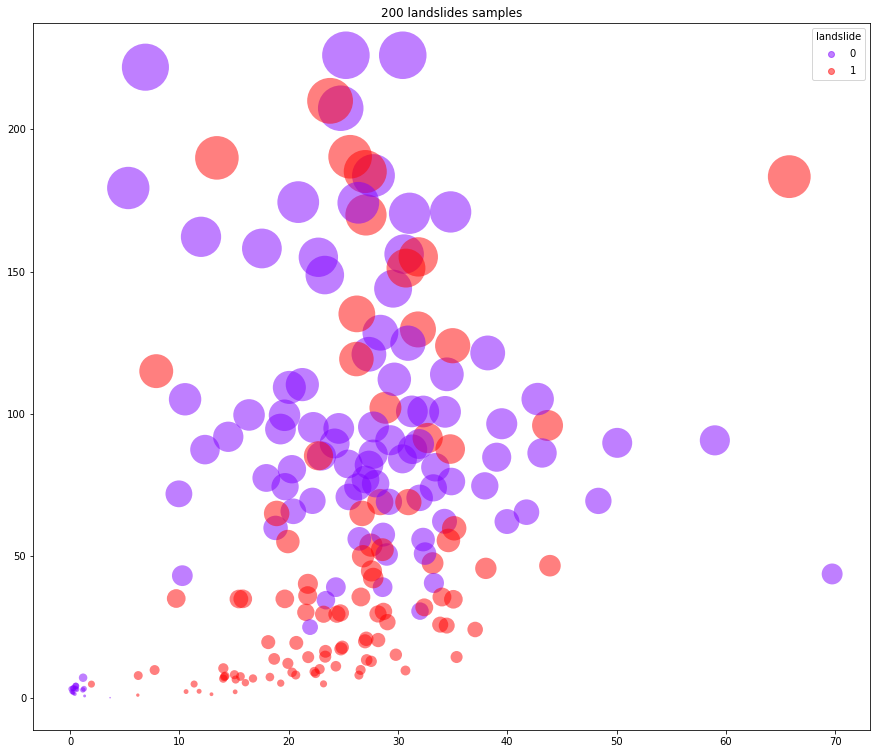

In [12]:
fig, ax = plt.subplots(figsize=(15,13))
sizes = dataset['elevation']*10
scatter = ax.scatter(dataset['slope'], dataset['elevation'], 
           c=(dataset['class']), cmap='rainbow', alpha=0.5,
           s=sizes, edgecolors='none')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

ax.title.set_text("{}{}".format(len(dataset.index), ' landslides samples')) 

plt.show()

### DataPrep
 - Based on the results of the feature importance analysis, all features were retained for training the ANN.
 - We addressed concerns about data leakage.

In [13]:
#features menos relevantes guaruja
#dataset = dataset.drop('elevation',axis=1)
#dataset = dataset.drop('curv',axis=1)
#dataset = dataset.drop('lito',axis=1)
#dataset = dataset.drop('uso_solo',axis=1)
# de fato, essas 3 features são irrelevantes pois a acurácia é similar sem elas no dataset
dataset = dataset[['slope','aspect','elevation','land_use','lithology','twi','curvature','class']]
dataset.head(5)

,slope,aspect,elevation,land_use,lithology,twi,curvature,class
0,27.338095,330.186584,120.943680,90,65,27.338095,0.002735,0
1,24.772690,113.472549,17.397917,20,2,5.155329,0.006004,1
2,24.757074,121.768433,207.428345,90,65,24.757074,0.000368,0
3,29.801399,71.881042,15.330963,20,2,6.688554,-0.010576,1
4,0.221845,185.550385,2.162373,70,2,0.221845,-0.000012,0


In [14]:
X_train, X_test, X_val, y_train, y_test, y_val = dataPreparation2(dataset)
#X_train, X_test, y_train, y_test = dataPreparation(dataset)

In [15]:
print(len(X_train), 'train examples')
print(len(X_val), 'validation examples')
print(len(X_test), 'test examples')

98 train examples
42 validation examples
60 test examples


In [16]:
print(X_train.min(axis=0), X_test.max(axis=0))

[-1. -1. -1. -1. -1. -1. -1.] [ 1.63025317  0.948116    1.03804377  1.          1.          1.35762042
 -0.98499636]


In [17]:
X = np.concatenate((X_train, X_val))
X = np.concatenate((X, X_test))

In [18]:
X.shape

(200, 7)

In [19]:
y = np.concatenate((y_train, y_val))
y = np.concatenate((y, y_test))

In [20]:
y.shape

(200, 1)

In [21]:
print(X.min(axis=0), X.max(axis=0))

[-1.         -1.00147197 -1.00818162 -1.         -1.         -1.
 -1.26211285] [1.78731424 1.00048694 1.03804377 1.         1.         1.78731424
 1.        ]


__Computa o número de variáveis de entrada (features) e saída (sempre 1)__

In [22]:
input_dim, output_dim = X_train.shape[1], y_train.shape[1]

### Custom neural network training

#### Hyperparameters tunning
- Brute force method
- custom classes and functions

In [23]:
class hyperparametros: 
    def __init__(self, acuracia, camadas,neuronios,learning_rate,batch_size,dropout): 
        self.acuracia = acuracia 
        self.camadas = camadas
        self.neuronios = neuronios 
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.dropout = dropout

In [24]:
class ANN_accuracy: 
    def __init__(self, acuracia, _neuralNetwork): 
        self.acuracia = acuracia 
        self.ann = _neuralNetwork

In [25]:
#patience = early stopping
def setBestNeuralNetwork(hidden_layers,neurons, num_learning_rate, droput, input_dim, output_dim):
    nn = NeuralNetwork(cost_func = rna.binary_cross_entropy, learning_rate = num_learning_rate, momentum=0.1, patience=50) 

    #input layer
    nn.layers.append(Layer(input_dim=input_dim, output_dim=neurons,activation= rna.relu, weights_initializer=rna.glorot_normal))

    for num_hidden_layers in range(1,hidden_layers+1,1):
        #nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,reg_func=rna.l2_regularization,reg_strength=1e-2))
        nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,dropout_prob = droput,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))

    #output layer
    nn.layers.append(Layer(input_dim=neurons, output_dim=output_dim,activation=rna.sigmoid,weights_initializer=rna.glorot_normal))  

    return nn

In [26]:
# (batch_size) implementa o mini-batch que acelera o tempo de treinamento, requer método de inicialização do mini-batch. 
#ideal que o batch_size seja multiplo do tamanho do conjunto de dados de treinamento, que aqui é de 128 
neurons = [7,8,12] 
# preciso encontrar uma forma de implementar a alteração do numero de neuronios na camada oculta variando 
# de n-2 até n+6
hidden_layers = [1,2,3]
learning_rate = [0.001,0.005,0.01]
batch_size = [0,4,8] 
dropout_rate = [0,0.1]
best_of_best_ANN = []
best_of_best_hyper = []

In [27]:
def setTestNeuralNetwork(hidden_layers,neurons, num_learning_rate, droput, input_dim, output_dim):
    #nn = NeuralNetwork(cost_func = rna.binary_cross_entropy, learning_rate = num_learning_rate, momentum=0.25, patience=50) 

    #camada de entrada
    print('\033[1m Input layer: {} inputs neurons  {} outputs neurons {} learning rate \033[0m'.format(input_dim, neurons,num_learning_rate))
    #nn.layers.append(Layer(input_dim=input_dim, output_dim=neurons,activation= rna.relu, weights_initializer=rna.glorot_normal))

    for num_hidden_layers in range(1,hidden_layers+1,1):
        print(' hidden layer {} neurons {} layers '.format(neurons,hidden_layers))
        #nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,reg_func=rna.l2_regularization,reg_strength=1e-2))
        #nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,dropout_prob = droput,weights_initializer=rna.glorot_normal))
    
    #nn.layers.append(Layer(input_dim=neurons, output_dim=output_dim,activation=rna.sigmoid,weights_initializer=rna.glorot_normal))  
    print('\033[1m {} last hidden layer neurons, {} output neurons \033[0m'.format(neurons,output_dim))

In [28]:
for num_hidden_layers in hidden_layers:
    for num_neurons_layers in neurons:
        for num_learning_rate in learning_rate:
            for num_batch_size in batch_size:
                for prob_dropout in dropout_rate:
                    setTestNeuralNetwork(num_hidden_layers,num_neurons_layers, num_learning_rate, prob_dropout, input_dim, output_dim)

 Input layer: 7 inputs neurons  7 outputs neurons 0.001 learning rate 
 hidden layer 7 neurons 1 layers 
 7 last hidden layer neurons, 1 output neurons 
 Input layer: 7 inputs neurons  7 outputs neurons 0.001 learning rate 
 hidden layer 7 neurons 1 layers 
 7 last hidden layer neurons, 1 output neurons 
 Input layer: 7 inputs neurons  7 outputs neurons 0.001 learning rate 
 hidden layer 7 neurons 1 layers 
 7 last hidden layer neurons, 1 output neurons 
 Input layer: 7 inputs neurons  7 outputs neurons 0.001 learning rate 
 hidden layer 7 neurons 1 layers 
 7 last hidden layer neurons, 1 output neurons 
 Input layer: 7 inputs neurons  7 outputs neurons 0.001 learning rate 
 hidden layer 7 neurons 1 layers 
 7 last hidden layer neurons, 1 output neurons 
 Input layer: 7 inputs neurons  7 outputs neurons 0.001 learning rate 
 hidden layer 7 neurons 1 layers 
 7 last hidden layer neurons, 1 output neurons 
 Input layer: 7 inputs neurons  7 outputs neurons 0.005 learning rate 
 hidden lay

 Input layer: 7 inputs neurons  8 outputs neurons 0.001 learning rate 
 hidden layer 8 neurons 3 layers 
 hidden layer 8 neurons 3 layers 
 hidden layer 8 neurons 3 layers 
 8 last hidden layer neurons, 1 output neurons 
 Input layer: 7 inputs neurons  8 outputs neurons 0.001 learning rate 
 hidden layer 8 neurons 3 layers 
 hidden layer 8 neurons 3 layers 
 hidden layer 8 neurons 3 layers 
 8 last hidden layer neurons, 1 output neurons 
 Input layer: 7 inputs neurons  8 outputs neurons 0.001 learning rate 
 hidden layer 8 neurons 3 layers 
 hidden layer 8 neurons 3 layers 
 hidden layer 8 neurons 3 layers 
 8 last hidden layer neurons, 1 output neurons 
 Input layer: 7 inputs neurons  8 outputs neurons 0.001 learning rate 
 hidden layer 8 neurons 3 layers 
 hidden layer 8 neurons 3 layers 
 hidden layer 8 neurons 3 layers 
 8 last hidden layer neurons, 1 output neurons 
 Input layer: 7 inputs neurons  8 outputs neurons 0.001 learning rate 
 hidden layer 8 neurons 3 layers 
 hidden lay

In [ ]:
lst_hyperP = []
lst_ANN = []
for num_hidden_layers in hidden_layers:
    for num_neurons_layers in neurons:
        for num_learning_rate in learning_rate:
            for num_batch_size in batch_size:
                for prob_dropout in dropout_rate:
                    nn = setBestNeuralNetwork(num_hidden_layers,num_neurons_layers, num_learning_rate, prob_dropout, input_dim, output_dim)
                    
                    nn.fit(X_train, y_train, epochs=40000,batch_gen= rna.batch_shuffle, batch_size=num_batch_size, verbose=3000)
                
                    y_pred = nn.predict(X_val)
                    accu = 100*accuracy_score(y_val, y_pred > 0.5)
                    #accu = 100*roc_auc_score(y_val, y_pred > 0.5)
                    lst_hyperP.append(hyperparametros(accu,num_hidden_layers,num_neurons_layers,num_learning_rate,num_batch_size,prob_dropout) )
                    lst_ANN.append(ANN_accuracy(accu,nn))
                    print('To {} neurons, {} layer(s),  {} learning rate, {} batch size, {} dropout rate, we have: \033[1m Accuracy: {:.2f}% \033[0m'.format(num_neurons_layers,num_hidden_layers,num_learning_rate,num_batch_size,prob_dropout, accu))

epoch:    0/40000 loss_train: 1.56831541 + 0.00000000 = 1.56831541 loss_val = 1.56831541
epoch: 3000/40000 loss_train: 0.41321902 + 0.00000000 = 0.41321902 loss_val = 0.41321902
epoch: 6000/40000 loss_train: 0.28665351 + 0.00000000 = 0.28665351 loss_val = 0.28665351
epoch: 9000/40000 loss_train: 0.19038210 + 0.00000000 = 0.19038210 loss_val = 0.19038210
epoch: 12000/40000 loss_train: 0.11219534 + 0.00000000 = 0.11219534 loss_val = 0.11219534
epoch: 15000/40000 loss_train: 0.08372737 + 0.00000000 = 0.08372737 loss_val = 0.08372737
epoch: 18000/40000 loss_train: 0.06918236 + 0.00000000 = 0.06918236 loss_val = 0.06918236
epoch: 21000/40000 loss_train: 0.06031171 + 0.00000000 = 0.06031171 loss_val = 0.06031171
epoch: 24000/40000 loss_train: 0.05414765 + 0.00000000 = 0.05414765 loss_val = 0.05414765
epoch: 27000/40000 loss_train: 0.04950660 + 0.00000000 = 0.04950660 loss_val = 0.04950660
epoch: 30000/40000 loss_train: 0.04581219 + 0.00000000 = 0.04581219 loss_val = 0.04581219
epoch: 33000/4

epoch: 3000/40000 loss_train: 0.11608807 + 0.00000000 = 0.11608807 loss_val = 0.11608807
epoch: 6000/40000 loss_train: 0.08061863 + 0.00000000 = 0.08061863 loss_val = 0.08061863
epoch: 9000/40000 loss_train: 0.07022027 + 0.00000000 = 0.07022027 loss_val = 0.07022027
epoch: 12000/40000 loss_train: 0.06075012 + 0.00000000 = 0.06075012 loss_val = 0.06075012
epoch: 15000/40000 loss_train: 0.05538212 + 0.00000000 = 0.05538212 loss_val = 0.05538212
epoch: 18000/40000 loss_train: 0.05118133 + 0.00000000 = 0.05118133 loss_val = 0.05118133
epoch: 21000/40000 loss_train: 0.04749536 + 0.00000000 = 0.04749536 loss_val = 0.04749536
epoch: 24000/40000 loss_train: 0.04397478 + 0.00000000 = 0.04397478 loss_val = 0.04397478
epoch: 27000/40000 loss_train: 0.04039085 + 0.00000000 = 0.04039085 loss_val = 0.04039085
epoch: 30000/40000 loss_train: 0.03700926 + 0.00000000 = 0.03700926 loss_val = 0.03700926
epoch: 33000/40000 loss_train: 0.03390392 + 0.00000000 = 0.03390392 loss_val = 0.03390392
epoch: 36000/

C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 7 neurons, 1 layer(s),  0.01 learning rate, 0 batch size, 0 dropout rate, we have:  Accuracy: 57.14% 
epoch:    0/40000 loss_train: 1.50823713 + 0.00000000 = 1.50823713 loss_val = 1.50823713
epoch: 3000/40000 loss_train: 0.09216418 + 0.00000000 = 0.09216418 loss_val = 0.09216418
epoch: 6000/40000 loss_train: 0.06617560 + 0.00000000 = 0.06617560 loss_val = 0.06617560
To 7 neurons, 1 layer(s),  0.01 learning rate, 0 batch size, 0.1 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 0.86637316 + 0.00000000 = 0.86637316 loss_val = 0.86637316
epoch: 3000/40000 loss_train: 0.05944029 + 0.00000000 = 0.05944029 loss_val = 0.05944029
epoch: 6000/40000 loss_train: 0.03587299 + 0.00000000 = 0.03587299 loss_val = 0.03587299
epoch: 9000/40000 loss_train: 0.02477531 + 0.00000000 = 0.02477531 loss_val = 0.02477531
epoch: 12000/40000 loss_train: 0.01757104 + 0.00000000 = 0.01757104 loss_val = 0.01757104
epoch: 15000/40000 loss_train: 0.01269389 + 0.00000000 = 0.01269389 loss_va

epoch: 33000/40000 loss_train: 0.05838129 + 0.00000000 = 0.05838129 loss_val = 0.05838129
epoch: 36000/40000 loss_train: 0.05499764 + 0.00000000 = 0.05499764 loss_val = 0.05499764
epoch: 39000/40000 loss_train: 0.05204909 + 0.00000000 = 0.05204909 loss_val = 0.05204909
To 8 neurons, 1 layer(s),  0.001 learning rate, 4 batch size, 0 dropout rate, we have:  Accuracy: 100.00% 
epoch:    0/40000 loss_train: 0.82273666 + 0.00000000 = 0.82273666 loss_val = 0.82273666
epoch: 3000/40000 loss_train: 0.62785892 + 0.00000000 = 0.62785892 loss_val = 0.62785892
epoch: 6000/40000 loss_train: 0.49804911 + 0.00000000 = 0.49804911 loss_val = 0.49804911
epoch: 9000/40000 loss_train: 0.32393655 + 0.00000000 = 0.32393655 loss_val = 0.32393655
epoch: 12000/40000 loss_train: 0.21977925 + 0.00000000 = 0.21977925 loss_val = 0.21977925
epoch: 15000/40000 loss_train: 0.16803981 + 0.00000000 = 0.16803981 loss_val = 0.16803981
epoch: 18000/40000 loss_train: 0.13971626 + 0.00000000 = 0.13971626 loss_val = 0.139716

epoch: 18000/40000 loss_train: 0.05171151 + 0.00000000 = 0.05171151 loss_val = 0.05171151
epoch: 21000/40000 loss_train: 0.04204380 + 0.00000000 = 0.04204380 loss_val = 0.04204380
To 8 neurons, 1 layer(s),  0.005 learning rate, 4 batch size, 0.1 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 0.78327757 + 0.00000000 = 0.78327757 loss_val = 0.78327757
epoch: 3000/40000 loss_train: 0.11762831 + 0.00000000 = 0.11762831 loss_val = 0.11762831
epoch: 6000/40000 loss_train: 0.08507498 + 0.00000000 = 0.08507498 loss_val = 0.08507498
epoch: 9000/40000 loss_train: 0.07158795 + 0.00000000 = 0.07158795 loss_val = 0.07158795
epoch: 12000/40000 loss_train: 0.05988722 + 0.00000000 = 0.05988722 loss_val = 0.05988722
epoch: 15000/40000 loss_train: 0.05468446 + 0.00000000 = 0.05468446 loss_val = 0.05468446
epoch: 18000/40000 loss_train: 0.05050242 + 0.00000000 = 0.05050242 loss_val = 0.05050242
epoch: 21000/40000 loss_train: 0.04685570 + 0.00000000 = 0.04685570 loss_val = 0.04685

C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
C:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 8 neurons, 1 layer(s),  0.01 learning rate, 0 batch size, 0 dropout rate, we have:  Accuracy: 57.14% 
epoch:    0/40000 loss_train: 0.78804363 + 0.00000000 = 0.78804363 loss_val = 0.78804363
epoch: 3000/40000 loss_train: 0.10031221 + 0.00000000 = 0.10031221 loss_val = 0.10031221
epoch: 6000/40000 loss_train: 0.05969013 + 0.00000000 = 0.05969013 loss_val = 0.05969013
epoch: 9000/40000 loss_train: 0.04599157 + 0.00000000 = 0.04599157 loss_val = 0.04599157
To 8 neurons, 1 layer(s),  0.01 learning rate, 0 batch size, 0.1 dropout rate, we have:  Accuracy: 95.24% 
epoch:    0/40000 loss_train: 1.19451333 + 0.00000000 = 1.19451333 loss_val = 1.19451333
epoch: 3000/40000 loss_train: 0.06965550 + 0.00000000 = 0.06965550 loss_val = 0.06965550
epoch: 6000/40000 loss_train: 0.04247008 + 0.00000000 = 0.04247008 loss_val = 0.04247008
epoch: 9000/40000 loss_train: 0.03350689 + 0.00000000 = 0.03350689 loss_val = 0.03350689
epoch: 12000/40000 loss_train: 0.02822817 + 0.00000000 = 0.02822817 loss_val

epoch: 15000/40000 loss_train: 0.10369470 + 0.00000000 = 0.10369470 loss_val = 0.10369470
epoch: 18000/40000 loss_train: 0.08629283 + 0.00000000 = 0.08629283 loss_val = 0.08629283
epoch: 21000/40000 loss_train: 0.07534573 + 0.00000000 = 0.07534573 loss_val = 0.07534573
epoch: 24000/40000 loss_train: 0.06780596 + 0.00000000 = 0.06780596 loss_val = 0.06780596
epoch: 27000/40000 loss_train: 0.06211584 + 0.00000000 = 0.06211584 loss_val = 0.06211584
epoch: 30000/40000 loss_train: 0.05762764 + 0.00000000 = 0.05762764 loss_val = 0.05762764
epoch: 33000/40000 loss_train: 0.05387638 + 0.00000000 = 0.05387638 loss_val = 0.05387638
epoch: 36000/40000 loss_train: 0.05067039 + 0.00000000 = 0.05067039 loss_val = 0.05067039
epoch: 39000/40000 loss_train: 0.04788078 + 0.00000000 = 0.04788078 loss_val = 0.04788078
To 12 neurons, 1 layer(s),  0.001 learning rate, 4 batch size, 0 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 1.24704772 + 0.00000000 = 1.24704772 loss_val = 1.247

epoch: 33000/40000 loss_train: 0.03245138 + 0.00000000 = 0.03245138 loss_val = 0.03245138
epoch: 36000/40000 loss_train: 0.02764372 + 0.00000000 = 0.02764372 loss_val = 0.02764372
epoch: 39000/40000 loss_train: 0.02304193 + 0.00000000 = 0.02304193 loss_val = 0.02304193
To 12 neurons, 1 layer(s),  0.005 learning rate, 4 batch size, 0 dropout rate, we have:  Accuracy: 100.00% 
epoch:    0/40000 loss_train: 0.85770124 + 0.00000000 = 0.85770124 loss_val = 0.85770124
epoch: 3000/40000 loss_train: 0.11992142 + 0.00000000 = 0.11992142 loss_val = 0.11992142
epoch: 6000/40000 loss_train: 0.08603146 + 0.00000000 = 0.08603146 loss_val = 0.08603146
epoch: 9000/40000 loss_train: 0.07379684 + 0.00000000 = 0.07379684 loss_val = 0.07379684
epoch: 12000/40000 loss_train: 0.06418463 + 0.00000000 = 0.06418463 loss_val = 0.06418463
epoch: 15000/40000 loss_train: 0.05644756 + 0.00000000 = 0.05644756 loss_val = 0.05644756
epoch: 18000/40000 loss_train: 0.05028505 + 0.00000000 = 0.05028505 loss_val = 0.05028

To 12 neurons, 1 layer(s),  0.01 learning rate, 8 batch size, 0 dropout rate, we have:  Accuracy: 100.00% 
epoch:    0/40000 loss_train: 1.30952680 + 0.00000000 = 1.30952680 loss_val = 1.30952680
epoch: 3000/40000 loss_train: 0.06365851 + 0.00000000 = 0.06365851 loss_val = 0.06365851
epoch: 6000/40000 loss_train: 0.03632744 + 0.00000000 = 0.03632744 loss_val = 0.03632744
epoch: 9000/40000 loss_train: 0.02362842 + 0.00000000 = 0.02362842 loss_val = 0.02362842
epoch: 12000/40000 loss_train: 0.01566564 + 0.00000000 = 0.01566564 loss_val = 0.01566564
epoch: 15000/40000 loss_train: 0.01084411 + 0.00000000 = 0.01084411 loss_val = 0.01084411
epoch: 18000/40000 loss_train: 0.00777305 + 0.00000000 = 0.00777305 loss_val = 0.00777305
epoch: 21000/40000 loss_train: 0.00575764 + 0.00000000 = 0.00575764 loss_val = 0.00575764
To 12 neurons, 1 layer(s),  0.01 learning rate, 8 batch size, 0.1 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 0.88786954 + 0.00000000 = 0.88786954 lo

epoch: 15000/40000 loss_train: 0.20278952 + 0.00000000 = 0.20278952 loss_val = 0.20278952
epoch: 18000/40000 loss_train: 0.13231186 + 0.00000000 = 0.13231186 loss_val = 0.13231186
epoch: 21000/40000 loss_train: 0.10407182 + 0.00000000 = 0.10407182 loss_val = 0.10407182
epoch: 24000/40000 loss_train: 0.09036703 + 0.00000000 = 0.09036703 loss_val = 0.09036703
epoch: 27000/40000 loss_train: 0.08097571 + 0.00000000 = 0.08097571 loss_val = 0.08097571
epoch: 30000/40000 loss_train: 0.07148854 + 0.00000000 = 0.07148854 loss_val = 0.07148854
epoch: 33000/40000 loss_train: 0.06511202 + 0.00000000 = 0.06511202 loss_val = 0.06511202
epoch: 36000/40000 loss_train: 0.05878833 + 0.00000000 = 0.05878833 loss_val = 0.05878833
epoch: 39000/40000 loss_train: 0.05365536 + 0.00000000 = 0.05365536 loss_val = 0.05365536
To 7 neurons, 2 layer(s),  0.001 learning rate, 8 batch size, 0.1 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 0.92974046 + 0.00000000 = 0.92974046 loss_val = 0.92

In [ ]:
best_hyper = max(lst_hyperP, key=lambda hyper: hyper.acuracia)
best_of_best_hyper.append( hyperparametros(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout) )
print('{:.2f}% was the best \033[1m accuracy\033[0m, having {} layers,{} neurons, {} of learning rate and {} of batch size as hyperparameters!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size))

In [ ]:
best_ann = max(lst_ANN, key=lambda hyper: hyper.acuracia)
best_of_best_ANN.append(ANN_accuracy(best_ann.acuracia,best_ann.ann))
print('{:.2f}% was the best\033[1m accuracy\033[0m, with ANN {} '.format(best_ann.acuracia,best_ann.ann))

In [ ]:
lst_hyperP.sort(key = lambda hyper: hyper.acuracia)
#[hyper.neuronios for hyper in lst_hyperP]
for best_hyper in lst_hyperP: 
  print('{:.2f}% was the best\033[1m accuracy\033[0m, having {} layers,{} neurons, {} of learning rate, {} of batch size and {} dropout rate as hyperparameters!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout))

In [ ]:
lst_hyperP = []
lst_ANN = []

#for num_learning_rate in learning_rate:
#    for num_batch_size in batch_size:
#        nn = setBestNeuralNetwork2(num_learning_rate, input_dim, output_dim)

#        nn.fit(X_train, y_train, epochs=46000,batch_gen= rna.batch_shuffle, batch_size=num_batch_size, verbose=3000)

#        y_pred = nn.predict(X_val)
#        accu = 100*accuracy_score(y_val, y_pred > 0.5)
        #accu = 100*roc_auc_score(y_val, y_pred > 0.5)
#        lst_hyperP.append( hyperparametros(accu,2,10,num_learning_rate,num_batch_size,0) )
#        lst_ANN.append(ANN_accuracy(accu,nn))
#        print('Para  {} learning rate, {} batch size, temos: \033[1m Acurácia: {:.2f}% \033[0m'.format(num_learning_rate,num_batch_size, accu))

In [ ]:
#best_hyper = max(lst_hyperP, key=lambda hyper: hyper.acuracia)
#best_of_best_hyper.append( hyperparametros(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout) )
#print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas,{} neurônios, {} de learning rate e {} de batch size!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size))

In [ ]:
#best_ann2 = max(lst_ANN, key=lambda hyper: hyper.acuracia)
#best_of_best_ANN.append(ANN_accuracy(best_ann2.acuracia,best_ann2.ann))
#print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com a rede {} '.format(best_ann2.acuracia,best_ann2.ann))

In [ ]:
#lst_hyperP.sort(key = lambda hyper: hyper.acuracia)
#[hyper.neuronios for hyper in lst_hyperP]
#for best_hyper in lst_hyperP: 
#  print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas, {} de learning rate, {} de batch size e {} dropout rate!'.format(best_hyper.acuracia,best_hyper.camadas, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout))

In [ ]:
#lst_hyperP = []
#lst_ANN = []

#for num_learning_rate in learning_rate:
#    for num_batch_size in batch_size:
#        nn = setBestNeuralNetwork3(num_learning_rate, input_dim, output_dim)

#        nn.fit(X_train, y_train, epochs=36000,batch_gen= rna.batch_shuffle, batch_size=num_batch_size, verbose=3000)

#        y_pred = nn.predict(X_val)
#        accu = 100*accuracy_score(y_val, y_pred > 0.5)
#        lst_hyperP.append( hyperparametros(accu,2,20,num_learning_rate,num_batch_size,0) )
#        lst_ANN.append(ANN_accuracy(accu,nn))
#        print('Para  {} learning rate, {} batch size, temos: \033[1m Acurácia: {:.2f}% \033[0m'.format(num_learning_rate,num_batch_size, accu))

In [ ]:
#best_hyper = max(lst_hyperP, key=lambda hyper: hyper.acuracia)
#best_of_best_hyper.append( hyperparametros(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout) )
#print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas,{} neurônios, {} de learning rate e {} de batch size!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size))

In [ ]:
#best_ann3 = max(lst_ANN, key=lambda hyper: hyper.acuracia)
#best_of_best_ANN.append(ANN_accuracy(best_ann3.acuracia,best_ann3.ann))
#print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com a rede {} '.format(best_ann3.acuracia,best_ann3.ann))

In [ ]:
#lst_hyperP.sort(key = lambda hyper: hyper.acuracia)
#[hyper.neuronios for hyper in lst_hyperP]
#for best_hyper in lst_hyperP: 
#  print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas, {} de learning rate, {} de batch size e {} dropout rate!'.format(best_hyper.acuracia,best_hyper.camadas, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout))

#### Evaluation

https://medium.com/mdr-inc/from-sgd-to-adam-c9fce513c4bb

In [ ]:
best_of_best_ANN_Test = []
for best_RNA in best_of_best_ANN: 
  bestNN = best_RNA.ann
  yhat_probs = bestNN.predict(X_test)
  yhat_classes = (yhat_probs > 0.5)
  accu = 100*accuracy_score(y_test,yhat_classes)
  accMedia = (accu + best_RNA.acuracia) / 2
  print('{:.2f}% accu_test - {:.2f}% foi a melhor\033[1m acurácia\033[0m, {:.2f} acc média {} RNA!'.format(accu,best_RNA.acuracia,accMedia,best_RNA.ann))
  accu = accMedia  
  best_of_best_ANN_Test.append(ANN_accuracy(accu,bestNN))

In [ ]:
for best_hyper in best_of_best_hyper: 
  print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas,{} neurônios, {} de learning rate, {} de batch size e {} dropout rate!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout))

In [ ]:
bestNN_Test = max(best_of_best_ANN_Test, key=lambda hyper: hyper.acuracia)
bestNN_Test = bestNN_Test.ann

In [ ]:
yhat_probs = bestNN_Test.predict(X_test)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_test,yhat_classes)
print('{:.2f}%, acurácia de teste !'.format(accu))

Segunda abordagem - configura uma nova rede com os parametros obtidos da otimização por força bruta

In [ ]:
bestNN = max(best_of_best_ANN_Test, key=lambda hyper: hyper.acuracia)
bestNN = bestNN.ann

In [ ]:
bestHyper = max(best_of_best_hyper, key=lambda hyper: hyper.acuracia)
print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas, {} de learning rate, {} de batch size e {} dropout rate!'.format(bestHyper.acuracia,bestHyper.camadas, bestHyper.learning_rate,bestHyper.batch_size,bestHyper.dropout))

In [ ]:
yhat_probs = bestNN.predict(X_test)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_test,yhat_classes)
print('{:.2f}%, acurácia de teste !'.format(accu))

In [ ]:
bstANN = bestNN
#bst_hyper = bstANN.hyper
print('{:.2f}% foi a melhor\033[1m acurácia\033[0m, obtida com {} camadas, {} de learning rate, {} de batch size e {} dropout rate!'.format(best_hyper.acuracia,best_hyper.camadas, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout))

#### Saving the best ANN architeture
 - Given the best set of hyperparameters, trained ANN is saved.

In [ ]:
if accu >= 85:
    print('{:.2f}%, excellent accuracy for test sample, ANN saved!'.format(accu))
    bestNN.save('bestANN\suscetibilidadeNN_guaruja.pkl')
else:
    print('Accuracy: {:.2f}% testing sample accuracy under .85!'.format(accu))

In [ ]:
y_pred = bestNN.predict(X_train)
print('Accuracy: {:.2f}%'.format(100*accuracy_score(y_train, y_pred > 0.5)))

In [ ]:
y_pred = bestNN.predict(X_val)
print('Accuracy: {:.2f}%'.format(100*accuracy_score(y_val, y_pred > 0.5)))

In [ ]:
y_pred = bestNN.predict(X_test)
print('Accuracy: {:.2f}%'.format(100*accuracy_score(y_test, y_pred > 0.5)))

In [ ]:
y_pred = bestNN.predict(X)
print('Accuracy: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

__Quando obtermos uma boa acurácia com os dados de teste, salvamos a rede devidamente treinada__

In [ ]:
yhat_probs = bestNN.predict(X_train)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_train, yhat_classes)
print('Acurácia: {:.2f}%'.format(accu))

In [ ]:
NetworkPerformance(y_train, yhat_probs)

In [ ]:
yhat_probs = bestNN.predict(X_test)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_test,yhat_classes)
print('Acurácia: {:.2f}%'.format(accu))

In [ ]:
NetworkPerformance(y_test, yhat_probs)

In [ ]:
yhat_probs = bestNN.predict(X_val)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_val,yhat_classes)
print('Acurácia: {:.2f}%'.format(accu))

In [ ]:
NetworkPerformance(y_val, yhat_probs)

In [ ]:
yhat_probs = bestNN.predict(X)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y,yhat_classes)
print('Acurácia: {:.2f}%'.format(accu))

In [ ]:
NetworkPerformance(y, yhat_probs)

In [ ]:
printAUROC(y,yhat_probs)

In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y,(yhat_probs > 0.5))

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('Predicted occurrences\nAcurácia={:0.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))
ax.set_ylabel('Actual occurrences ')


## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
output_proprietario = None
output_proprietario = dataset_original
output_proprietario['score'] = yhat_probs

In [ ]:
sizes = output_proprietario['slope']*10

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 9))

axes[0].scatter(output_proprietario['slope'], output_proprietario['elevation'],
            c=(output_proprietario['class']), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
legend1 = axes[0].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

axes[1].scatter(output_proprietario['slope'], output_proprietario['elevation'],
            c=(output_proprietario['score'] > 0.5), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
legend1 = axes[1].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

fig.tight_layout()
text = 'deslizamentos preditos ' + 'acurácia de: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5))
axes[0].title.set_text('deslizamentos reais')
axes[1].title.set_text(text)

plt.show()

Agora considerar __RepeatedStratifiedKfold__ para avaliação da rede

ref. https://www.geeksforgeeks.org/stratified-k-fold-cross-validation/

ref. https://medium.com/@venkatasujit272/overview-of-cross-validation-3785d5414ece

In [ ]:
# Teste com objeto StratifiedKFold.
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
import statistics 

In [ ]:
#X = dataset.drop('class',axis=1)
#y= dataset['class']
#X = X.to_numpy()    #converts dataframe into array to be used at NN
#y = y.to_numpy()    #converts dataframe into array to be used at NN
#y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1

#normalização do dataset
#minmax = MinMaxScaler(feature_range=(-1, 1))
#minmax = MinMaxScaler()
#X = minmax.fit_transform(X.astype(np.float64))
print(X.min(axis=0), X.max(axis=0))

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lst_accu_stratified = []

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2,random_state=36851234)

print ('Numero de Splits_stratified de X: ',rskf.get_n_splits(X, y),'\n')

# Prin_stratifiedting the Train & Test Indices of splits
for train_index, test_index in rskf.split(X, y): 
    #print ("TRAIN:", train_index, "TEST:", test_index)
    X_train_stratified, X_test_stratified = X[train_index], X[test_index]
    y_train_stratified, y_test_stratified = y[train_index], y[test_index]
    print(X_train_stratified.shape, y_train_stratified.shape)
    
    yhat_probs = bestNN.predict(X_test_stratified)
    lst_accu_stratified.append(100*accuracy_score(y_test_stratified, yhat_probs > 0.5))

In [ ]:
print('Lista de acurácias obtidas:', lst_accu_stratified)
print('\nAcurácia máxima obtida:',
      max(lst_accu_stratified), '%')
print('\nAcurácia mínima:',
      min(lst_accu_stratified), '%')
print('\nAcurácia média:',
      statistics.mean(lst_accu_stratified), '%')
print('\nDesvio Padrão:', statistics.stdev(lst_accu_stratified))

Recupera modelo otimizado saldo anteriormente e o testa com diferentes conjuntos de dados.

In [ ]:
dataset

In [ ]:
y_pred = bestNN.predict(X)
yhat_classes = (y_pred > 0.5)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))
output_proprietario = None
output_proprietario = dataset_original
output_proprietario['score'] = y_pred
output_proprietario.to_csv('bestANN/mapaSuscetibilidade_proprietaria.csv', encoding="utf-8")

In [ ]:
NetworkPerformance(y, y_pred)

In [ ]:
output_proprietario

In [ ]:
from matplotlib import pyplot
ns_auc = roc_auc_score(y, y_pred)
# summarize scores
print('ROC AUC=%.3f' % (ns_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, y_pred)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='ROC AUC')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

- ref. https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
- ref. https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

In [ ]:
sizes = output_proprietario['elevation']*10

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 9))

axes[0].scatter(output_proprietario['slope'], output_proprietario['elevation'],
            c=(output_proprietario['class']), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
legend1 = axes[0].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

axes[1].scatter(output_proprietario['slope'], output_proprietario['elevation'],
            c=(output_proprietario['score'] > 0.5), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
legend1 = axes[1].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

fig.tight_layout()
text = 'deslizamentos preditos ' + 'acurácia de: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5))
axes[0].title.set_text('deslizamentos reais')
axes[1].title.set_text(text)

plt.show()

In [ ]:
dataSet = output_proprietario.sample(n = 50)
#dataSet = dataSet.drop('FID',axis=1)
#dataSet = dataSet.drop('X',axis=1)
#dataSet = dataSet.drop('Y',axis=1)
plotSwarmChart(dataSet)

In [ ]:
# perguntar para Ale como retornar os dados para ela, se em um csv com cada posição e as respectivas probabilidades?
# se for, basta incorporar essa variável y_pred à uma nova coluna do dataframe

In [ ]:
end = datetime.datetime.now()
print(end-start)
quit()

### Keras neural network
__Problema de classificação, considerar as melhores práticas:__
- Ajuste dos hiperparametros
- Baseline para implementação customizada

ref. https://machinelearningmastery.com/data-preparation-without-data-leakage/


Agora, configura a rede com os melhores parâmetros

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import tensorflow as tf

In [ ]:
print(len(X_train), 'train examples')
print(len(X_val), 'validation examples')
print(len(X_test), 'test examples')

In [ ]:
#{'num_hidden_layers': 1, 'num_units': 4, 'dropout_rate': 0.5, 'learning_rate': 0.004682800657889146}       

In [ ]:
#HyperParameters: {'num_hidden_layers': 2, 'num_units': 12, 'dropout_rate': 0.2821478566400208, 'learning_rate': 0.006549533067877217}
#conjunto de hyperparametros para o Guaruja 87% acuracia dados de teste.

In [ ]:
hypermodel = keras.Sequential()
hypermodel.add(Dense(24, activation='relu', input_dim=input_dim))

hypermodel.add(Dense(24, activation='relu'))
hypermodel.add(Dropout(0.43719886068153724))

#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))
#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))
#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))
#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))
#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))
#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))
#hypermodel.add(Dense(24, activation='relu'))
#hypermodel.add(Dropout(0.5))

hypermodel.add(Dense(1, activation='sigmoid'))
learning_rate= 0.01
myOptimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
hypermodel.compile(optimizer=myOptimizer, loss="binary_crossentropy", metrics=['accuracy'])

In [ ]:
#model.fit(X_train, y_train, epochs=100, batch_size=5)
history           = hypermodel.fit(X_train, y_train, epochs=500, batch_size=5)
val_acc_per_epoch = history.history['accuracy']
best_epoch        = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1

In [ ]:
print('Best epoch: %d' % (best_epoch,))

In [ ]:
# avaliação via keras
_, accuracy = hypermodel.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

In [ ]:
# Retrain the model
history = hypermodel.fit(X_train, y_train, epochs=best_epoch)

In [ ]:
# avaliação via keras
_, accuracy = hypermodel.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

In [ ]:
import tensorflow as tf
# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(hypermodel, show_shapes=True, rankdir="LR")

In [ ]:
if accuracy >= .80:
    print('ótima acurácia, rede salva!')
    hypermodel.save('bestANN\suscetibilidadeKeras_guaruja.pkl')
else:
    print('acurácia abaixo de .85')

#### Assessment

In [ ]:
#X = dataset.drop('class',axis=1)
#y = dataset['class']
#X = X.to_numpy()    #converts dataframe into array to be used at NN
#y = y.to_numpy()    #converts dataframe into array to be used at NN
#y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1

#normalização do dataset
#minmax = MinMaxScaler(feature_range=(-1, 1))
#X = minmax.fit_transform(X.astype(np.float64))
#print(X.min(axis=0), X.max(axis=0))

In [ ]:
#X

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lst_accu_stratified = []

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2,random_state=36851234)

print ('Numero de Splits de X: ',rskf.get_n_splits(X, y),'\n')

# Printing the Train & Test Indices of splits
for train_index, test_index in rskf.split(X, y): 
    #print ("TRAIN:", train_index, "TEST:", test_index)
    X_train_stratified_keras, X_test_stratified_keras = X[train_index], X[test_index]
    y_train_stratified_keras, y_test_stratified_keras = y[train_index], y[test_index]
    #print('novo dataset')
    #print(X_train_stratified_keras.shape, y_train_stratified_keras.shape)
    
    yhat_probs = hypermodel.predict(X_test_stratified_keras)
    lst_accu_stratified.append(100*accuracy_score(y_test_stratified_keras, yhat_probs > 0.5))

In [ ]:
print('Lista de acurácias obtidas:', lst_accu_stratified)
print('\nAcurácia máxima obtida:',
      max(lst_accu_stratified), '%')
print('\nAcurácia mínima:',
      min(lst_accu_stratified), '%')
print('\nAcurácia média:',
      statistics.mean(lst_accu_stratified), '%')
print('\nDesvio Padrão:', statistics.stdev(lst_accu_stratified))

In [ ]:
y_pred = hypermodel.predict(X_test)
#print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_test, y_pred > 0.5)))

In [ ]:
y_pred = hypermodel.predict(X_train)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_train, y_pred > 0.5)))

In [ ]:
y_pred = hypermodel.predict(X_val)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y_val, y_pred > 0.5)))

In [ ]:
y_pred = hypermodel.predict(X)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

In [ ]:
output_keras = None
output_keras = dataset_original
output_keras['score'] = y_pred
output_keras.to_csv('bestANN/mapaSuscetibilidade_keras.csv', encoding="utf-8")
output_keras

In [ ]:
ns_auc = roc_auc_score(y, y_pred)
# summarize scores
print('ROC AUC=%.3f' % (ns_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, y_pred)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='ROC AUC')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
sizes = output_proprietario['elevation']*10

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 9))

axes[0].scatter(output_proprietario['slope'], output_proprietario['elevation'],
            c=(output_proprietario['class']), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
legend1 = axes[0].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

axes[1].scatter(output_proprietario['slope'], output_proprietario['elevation'],
            c=(output_proprietario['score'] > 0.5), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
legend1 = axes[1].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

fig.tight_layout()
text = 'deslizamentos preditos ' + 'acurácia de: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5))
axes[0].title.set_text('deslizamentos reais')
axes[1].title.set_text(text)

plt.show()

In [ ]:
dataSet = output_keras.sample(n = 50)
#dataSet = dataSet.drop('FID',axis=1)
#dataSet = dataSet.drop('X',axis=1)
#dataSet = dataSet.drop('Y',axis=1)
plotSwarmChart(dataSet)

In [ ]:
end = datetime.datetime.now()
print(end-start)

## References
- ref.1: https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers
- ref.2: https://www.tensorflow.org/tutorials/structured_data/feature_columns
- ref.3: https://realpython.com/train-test-split-python-data/
- ref.4: https://machinelearningmastery.com/data-preparation-without-data-leakage/
- ref.5: https://towardsdatascience.com/data-leakage-in-machine-learning-10bdd3eec742
- ref.6: https://analyticsindiamag.com/what-is-data-leakage-in-ml-why-should-you-be-concerned/
- ref.7: https://www.section.io/engineering-education/data-leakage/
- ref.8: https://medium.com/analytics-vidhya/overfitting-vs-data-leakage-in-machine-learning-ec59baa603e1
- ref.9: https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/